In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']

import seaborn as sns

In [2]:
def diff_month(d1, d2):
    
    '''returns difference in months between two datetime objects'''
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def car_name(row):
    
    '''From dataframe row create a sensible name to identify car'''
    
    # index of row
    idx = row.name.strip()
    # fill NaN
    row.fillna({
        'inspection_age':-999.,
        'age':-999.,
    },inplace=True)
    # translate str to datatime object
    auct = pd.datetime.strptime(idx[0:-5],'%Y-%m')
    # Manufacture date and year
    mf = auct - pd.to_timedelta(row.age, unit='days')
    mfy = "'" + str(mf.year)[-2:]
    # Inspection date and diff in months
    apk = auct - pd.to_timedelta(row.days_since_inspection_invalid, unit='days')
    apk_month = diff_month(auct,apk)
    
    # construct name    
    name = '{} {:7} {} {} {} {:g}drs {:g}cc {:g}cyl {} {:.1f}km/day '.format(
        mfy,
        row.color,
        row.brand,
        row.model,
        row.body_type,
        row.number_of_doors,
        row.displacement,
        row.number_of_cylinders,
        row.fuel,
        row.odometer/row.age)
    
    # add inspection if any
    if row.days_since_inspection_invalid > 0:
        name += 'inspection invalid'
    else:
        name += 'inspection {:g}m'.format(-apk_month)
        
    return name


In [3]:
fn = '../data/cars-for-ml.pkl'
print(fn)
df = pd.read_pickle(fn)
print(df.columns)

# cetegories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color']
print(list(df[cat_columns]))

# sensible name
df['car_name'] = df.apply(car_name,axis='columns')


../data/cars-for-ml.pkl
Index(['price', 'brand', 'model', 'age', 'fuel', 'odometer',
       'days_since_inspection_invalid', 'age_at_import', 'body_type',
       'displacement', 'number_of_cylinders', 'power', 'power2', 'weight',
       'registration_tax', 'sale_price', 'number_of_seats', 'number_of_doors',
       'color'],
      dtype='object')
['brand', 'model', 'fuel', 'body_type', 'color']


# Price

In [4]:
def get_nr_nc(n):
    nr = int(pd.np.ceil(n**(1/2)))
    nc = int(pd.np.floor(n/nr))
    return nr,nc

['age' 'age_at_import' 'days_since_inspection_invalid' 'displacement'
 'number_of_cylinders' 'number_of_doors' 'number_of_seats' 'odometer'
 'power' 'power2' 'registration_tax' 'sale_price' 'weight']


Text(0, 0.5, 'price [EUR]')

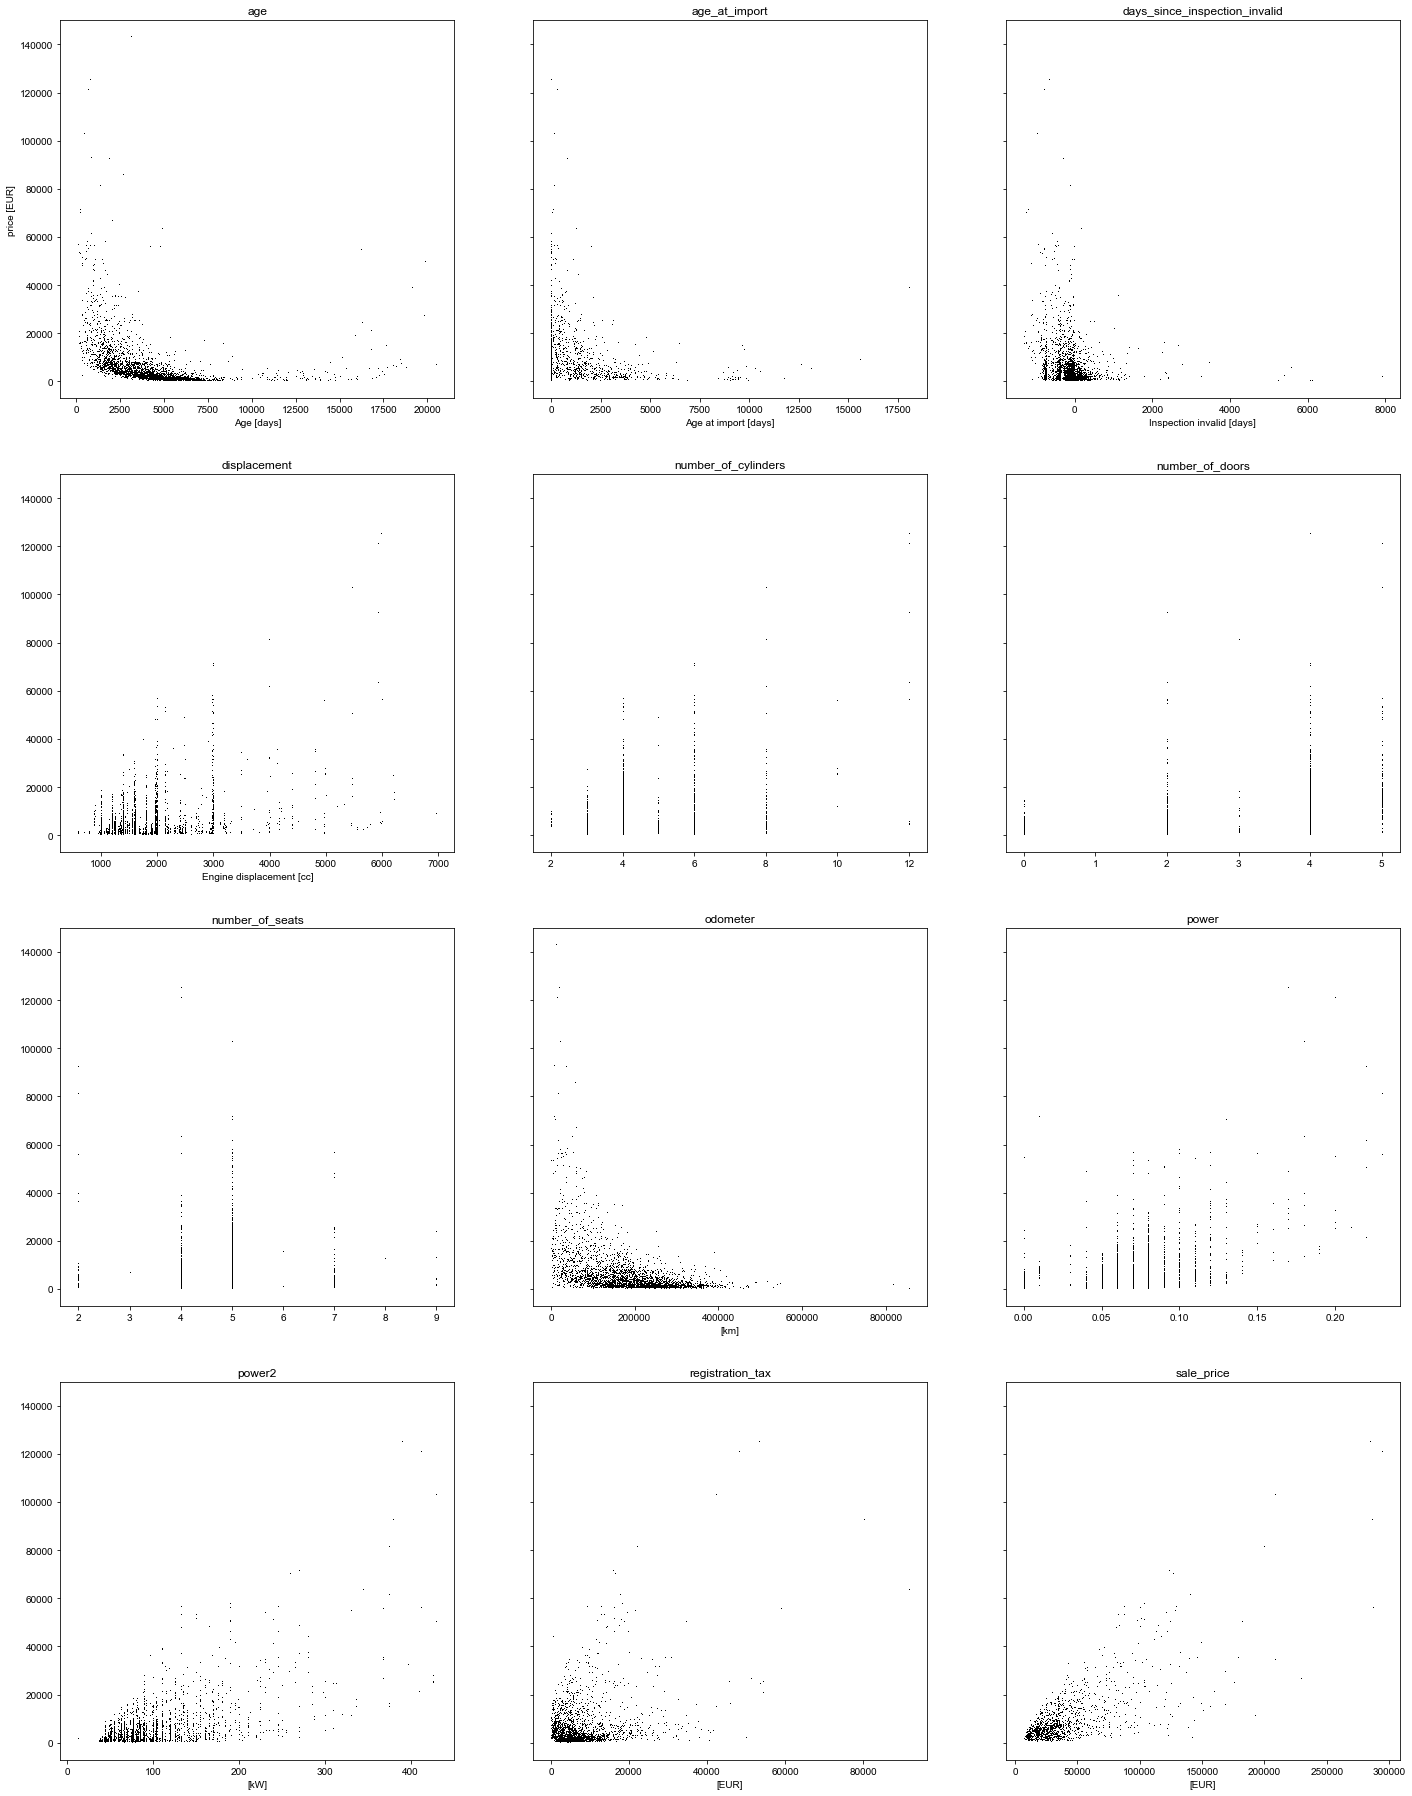

In [5]:
feat = pd.np.setdiff1d(df.columns, cat_columns + ['price', 'car_name'])
X = df.loc[:,feat]
y = df.price
print(feat)


nr,nc = get_nr_nc(len(feat))
fig,axs = plt.subplots(nrows=nr, ncols=nc, figsize=[8*nc,8*nr], sharey=True)

for iF,ax in enumerate(axs.ravel()):
    ax.plot(X.iloc[:,iF],y,',k')
    ax.set_title(feat[iF])
    if feat[iF] == 'displacement':
        ax.set_xlabel('Engine displacement [cc]')
    elif feat[iF] == 'age':
        ax.set_xlabel('Age [days]')
    elif feat[iF] == 'age_at_import':
        ax.set_xlabel('Age at import [days]')
    elif feat[iF] == 'days_since_inspection_invalid':
        ax.set_xlabel('Inspection invalid [days]')
    elif feat[iF] == 'power':
        #vermogen_massarijklaar
        pass
    elif feat[iF] == 'power2':
        #nettomaximumvermogen
        ax.set_xlabel('[kW]')
    elif feat[iF] == 'odometer':
        ax.set_xlabel('[km]')
    elif feat[iF] == 'registration_tax':
        ax.set_xlabel('[EUR]')
    elif feat[iF] == 'sale_price':
        ax.set_xlabel('[EUR]')

    
    
axs.ravel()[0].set_ylabel('price [EUR]')


In [6]:
yX = pd.concat([pd.DataFrame(y), X], axis='columns').fillna(pd.np.NaN)

# group per car brand
yX['brand'] = df.brand
grouped = yX.groupby('brand')
VW = grouped.get_group('VOLKSWAGEN')
RENAULT = grouped.get_group('RENAULT')
MERC = grouped.get_group('MERCEDES-BENZ')
FORD = grouped.get_group('FORD')

Text(0.5, 0.98, 'Mercedes\nAll numerical features')

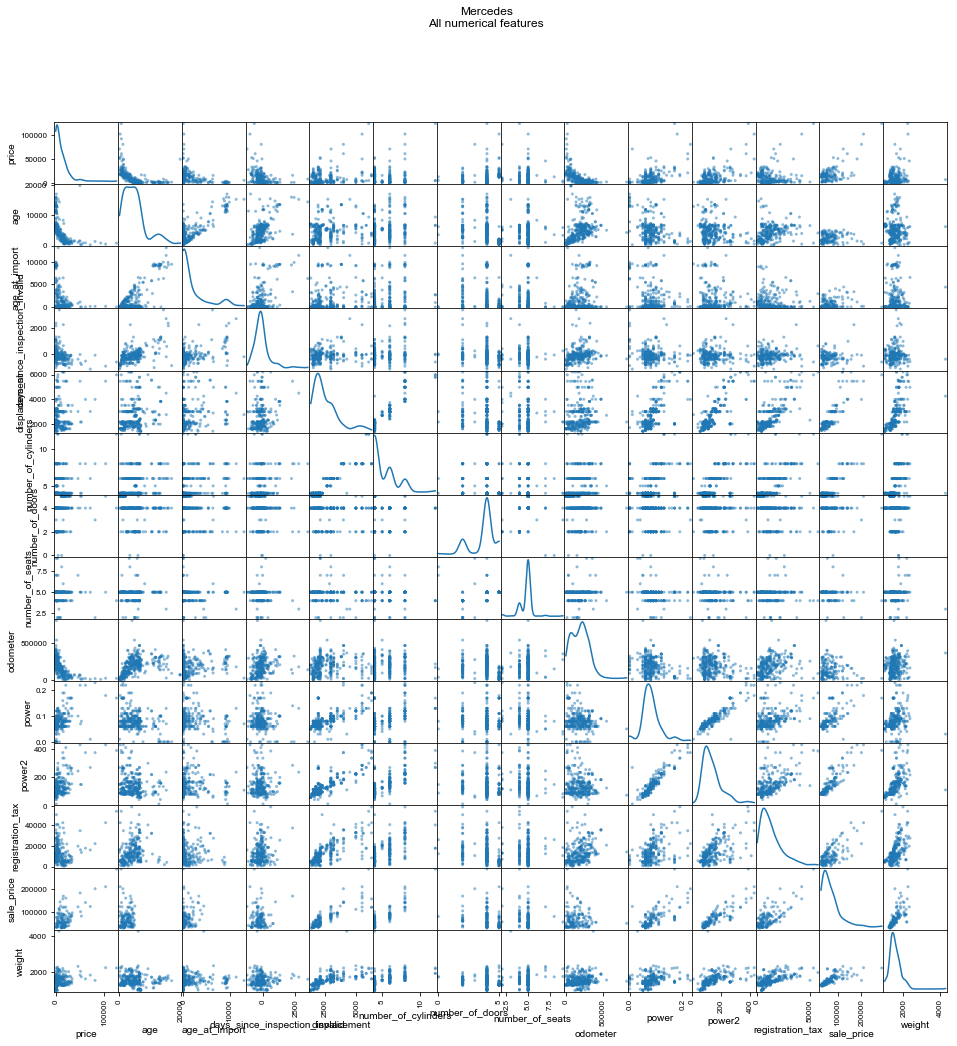

In [7]:
pd.plotting.scatter_matrix(MERC, grid=True, figsize=[16,16], diagonal='kde')
plt.suptitle('Mercedes\nAll numerical features')

# Distributions

In [8]:
def ecdf(data):
    d = data[data.notna()]
    y = pd.np.linspace(0,1,len(d))
    x = sorted(d)
    return x,y

## Age at import

Text(0.5, 1.0, 'old')

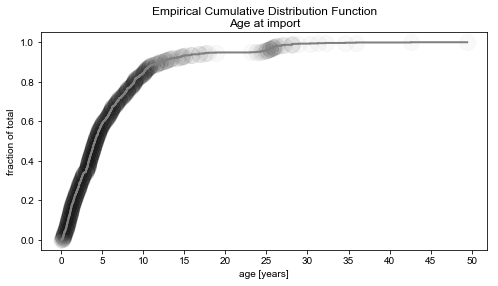

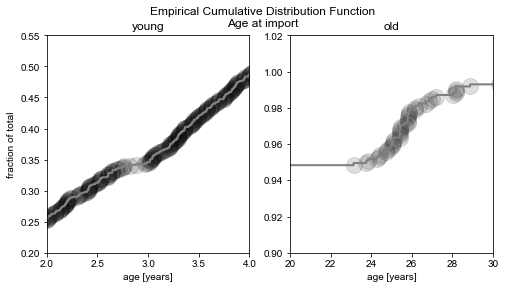

In [9]:
data = yX.age_at_import[yX.age_at_import>0]/365.25
x,y = ecdf(data)

# plot full
plt.figure(figsize=[8,4])
plt.step(x, y, color='k', marker='o', alpha=0.025, ms=16)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.title('Empirical Cumulative Distribution Function\nAge at import')
plt.xlabel('age [years]')
plt.ylabel('fraction of total')
plt.xticks(range(0,55,5))


# plot old/young
fig,axs = plt.subplots(figsize=[8,4], ncols=2, nrows=1)
axs[0].step(x, y, color='k', marker='o', alpha=0.125, ms=16)
axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1].step(x, y, color='k', marker='o', alpha=0.125, ms=16)
axs[1].step(x, y, color='grey', linestyle='-', linewidth=2)
fig.suptitle('Empirical Cumulative Distribution Function\nAge at import')
axs[0].set_xlim(left=2, right=4)
axs[1].set_xlim(left=20, right=30)
axs[0].set_ylim(bottom=0.2, top=0.55)
axs[1].set_ylim(bottom=0.9, top=1.02)
axs[0].set_ylabel('fraction of total')
axs[0].set_xlabel('age [years]')
axs[1].set_xlabel('age [years]')
axs[0].set_title('young')
axs[1].set_title('old')


# Dendrogram

This is a form of classification and produce a tree-like visualization


cluster 1

	'14 ZWART   VOLKSWAGEN golf stationwagen 5drs 1395cc 4cyl benzine 38.9km/day inspection 13m
	'13 BLAUW   VOLKSWAGEN golf stationwagen 5drs 1395cc 4cyl benzine 25.9km/day inspection 0m
	'15 BRUIN   VOLKSWAGEN golf stationwagen 5drs 1395cc 4cyl benzine 43.3km/day inspection 20m
	'12 WIT     VOLKSWAGEN polo hatchback 5drs 1390cc 4cyl benzine 36.5km/day inspection 27m
	'14 BLAUW   VOLKSWAGEN golf stationwagen 5drs 1395cc 4cyl benzine 41.0km/day inspection 17m
	'15 BLAUW   VOLKSWAGEN golf stationwagen 5drs 1197cc 4cyl benzine 7.1km/day inspection 28m
	'16 BRUIN   VOLKSWAGEN touran mpv 5drs 1395cc 4cyl benzine 91.3km/day inspection 30m
	'11 WIT     VOLKSWAGEN polo hatchback 2drs 1390cc 4cyl benzine 15.1km/day inspection 25m
	'10 GRIJS   VOLKSWAGEN polo hatchback 4drs 1198cc 3cyl benzine 25.5km/day inspection 14m
	'10 BLAUW   VOLKSWAGEN polo hatchback 4drs 1390cc 4cyl benzine 2.7km/day inspection 8m
	'15 WIT     VOLKSWAGEN golf stationwagen 5drs 1984cc 4cyl benzine 29.0km/day ins

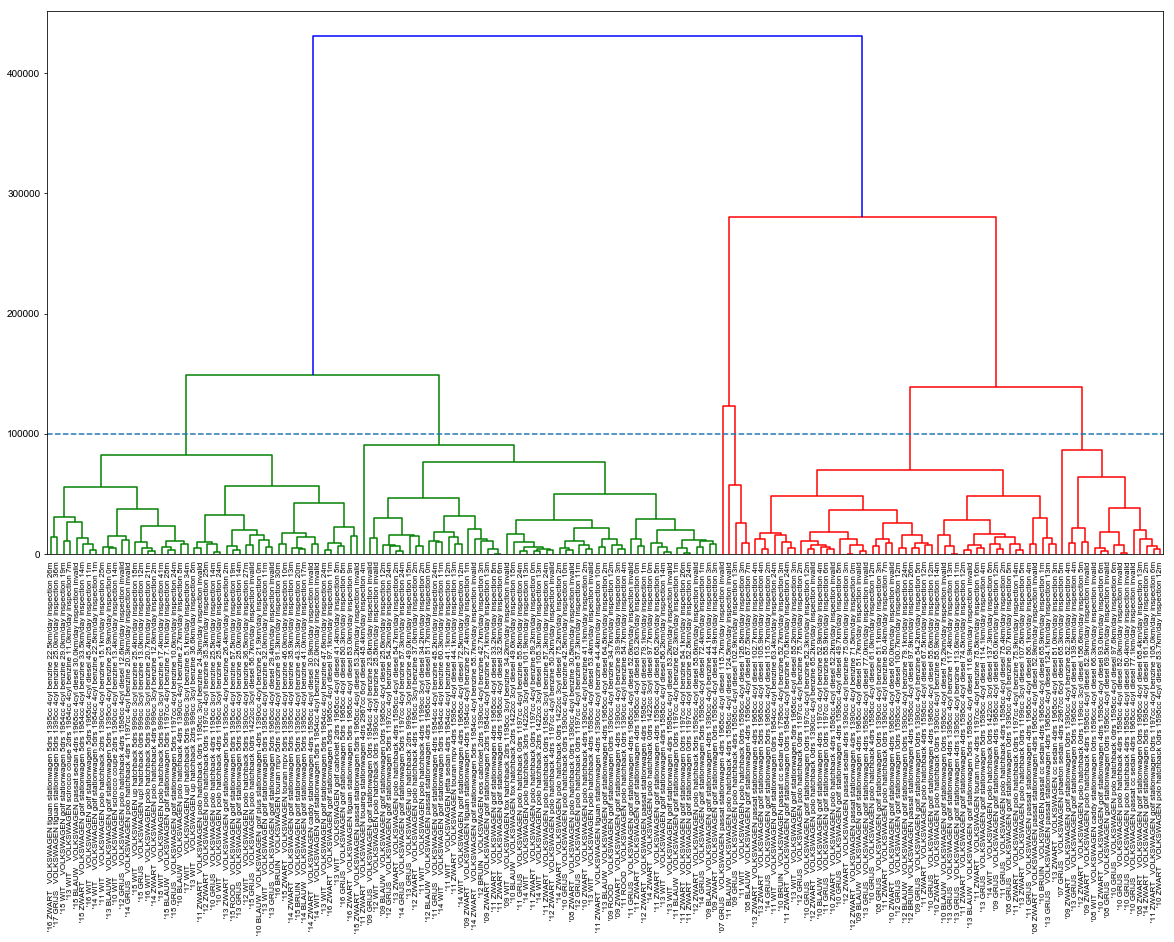

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

pd.np.random.seed(42)

train = VW.drop(columns='brand').dropna()

mergings = linkage(train,method='complete')
brand_names = df.loc[train.index,'brand']
model_names = df.loc[train.index,'model']
color_names = df.loc[train.index,'color']
fuel_names = df.loc[train.index,'fuel']
lot_names = df.loc[train.index,:].index
names = df.loc[train.index,"car_name"]
# names = brand_names
plt.figure(figsize=[20,10])
dendrogram(mergings,
           labels=names,
           leaf_rotation=90,
           leaf_font_size=8,
          );

level = 100000 # arbitrary!
plt.plot([0,train.shape[0]*10],[level,level],'--')
labels = fcluster(mergings,level,criterion='distance')

for l in range(1,labels.max()+1):
    print('\ncluster {}\n'.format(l))
    idx = train[labels == l].index
    for i in idx:
        print('\t{}'.format(df.loc[i,"car_name"]))
    

# tSNE

see if there are clusters

#### Train

In [11]:
from sklearn.manifold import TSNE

train = df.drop(columns=['brand','model','fuel','body_type','color','car_name']).dropna()

model = TSNE(learning_rate = 100,verbose=1)
transformed = model.fit_transform(train)
train.describe()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 960 samples in 0.001s...
[t-SNE] Computed neighbors for 960 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 960 / 960
[t-SNE] Mean sigma: 3689.292209
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.942543
[t-SNE] KL divergence after 1000 iterations: 0.417922


,price,age,odometer,days_since_inspection_invalid,age_at_import
count,960.000000,960.000000,960.000000,960.000000,960.000000
mean,10794.612500,2564.650000,139765.449784,-246.044792,453.262500
std,12335.418181,1240.952662,93242.526586,392.800412,830.329139
min,405.000000,138.000000,52.000000,-1314.000000,0.000000
25%,3698.250000,1625.250000,68133.500000,-428.000000,0.000000
50%,6987.500000,2492.500000,129050.000000,-209.500000,0.000000
75%,13654.750000,3493.500000,195819.500000,-55.250000,576.250000
max,125000.000000,5975.000000,816757.000000,2775.000000,4616.000000


#### plot

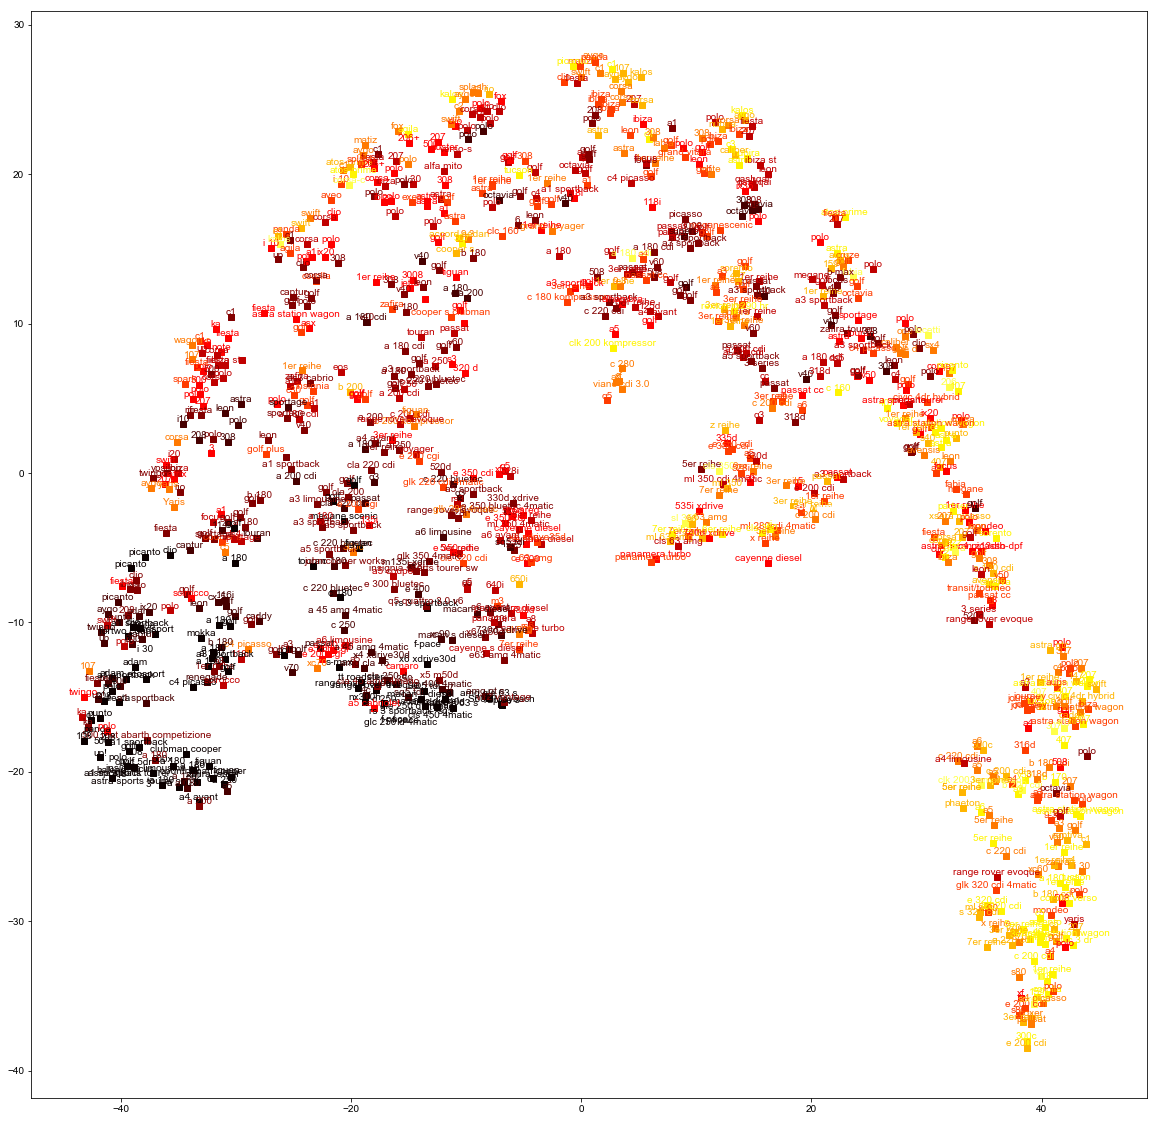

In [12]:
# Labeling

# year
year_bins = pd.np.arange(
    df.loc[train.index,"age"].min(),
    df.loc[train.index,"age"].max(),365)
year_labels = [i for i in range(len(year_bins)-1)]

# price
price_bins = pd.np.arange(
    df.loc[train.index,"price"].min(),
    df.loc[train.index,"price"].max(),500)
price_labels = [i for i in range(len(price_bins)-1)]

# color, fuel, brand
labels = df.loc[train.index,'color']
labels = df.loc[train.index,'fuel']
labels = df.loc[train.index,'brand']
labels = pd.factorize(labels)[0]

labels = pd.cut(train.age,bins=year_bins,labels=year_labels)
labels = pd.cut(train.age,bins=price_bins,labels=price_labels)

# name labels
names = df.loc[train.index,'model']

# plot
xs = transformed[:,0]
ys = transformed[:,1]
plt.figure(figsize=[20,20])
plt.set_cmap('hot')
plt.scatter(xs,ys,c=labels,marker='s')
cm=plt.get_cmap()
# text labels
for x,y,t,l in zip(xs,ys,names,labels):
    c = cm(l/max(labels))
    plt.text(x,y,t,color=c,ha='center',va='bottom')


- - - - 
# Results

The results here below surpass eda and are beter made suitable for publication
- - - - 

# Last digits of price

In [13]:
# 2d hist
last0_digit = df.price.dropna().astype(str).apply(lambda x:x[-3]).astype(int)
last1_digit = df.price.dropna().astype(str).apply(lambda x:x[-4]).astype(int)
cnt,b0,b1 = pd.np.histogram2d(last1_digit, last0_digit, bins=[10,10],range=[(-0.5,9.5),(-0.5,9.5)])
_xx, _yy = pd.np.meshgrid(b0[1:]-.5, b1[1:]-.5)
x, y = _xx.ravel(), _yy.ravel()

# normalize to expected value if homogenous
norm_cnt = pd.np.log10(cnt/(cnt.ravel().sum()/100))

# sort reversed
idx = cnt.ravel().argsort()[::-1]

digits = pd.DataFrame(data={
    'occurrence':cnt.ravel().astype(int),
    'normalized':norm_cnt.ravel()[idx],
    'last-1':y.astype(int),
    'last-0':x.astype(int),
    'last 2 digits':['{:02.0f}'.format(f) for f in (y*10 + x)]
}).set_index('last 2 digits')
digits.sort_values(by='occurrence', ascending=False, inplace=True)
digits

,occurrence,normalized,last-1,last-0
last 2 digits,,,,
00,279,0.984556,0,0
50,111,-0.138829,5,0
11,109,0.237922,1,1
55,100,-0.160018,5,5
01,72,0.584275,0,1
77,70,-0.506806,7,7
89,61,-0.858988,8,9
88,60,-0.762078,8,8
60,54,-0.284957,6,0


In [14]:
digits_max = digits.iloc[0,[c in ['last-1','last-0'] for c in digits.columns]]
digits_min = digits.iloc[-1,[c in ['last-1','last-0'] for c in digits.columns]]

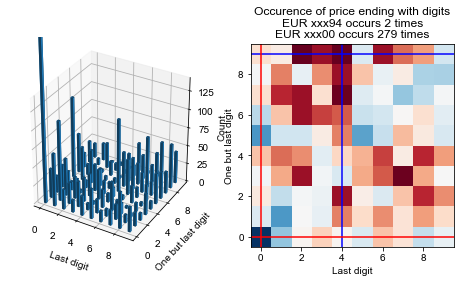

In [15]:
# plot
from mpl_toolkits.mplot3d import Axes3D

width = depth = .25
bottom = pd.np.zeros_like(cnt.ravel())

fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(x,y,bottom,width,depth,cnt.ravel())

ax2 = fig.add_subplot(122)
ax2.imshow(norm_cnt,vmax=+1,vmin=-1,
           cmap='RdBu',
           origin='lower')

plt.hlines(digits_min[0],-0.5,9.5,color='b')
plt.vlines(digits_min[1],-0.5,9.5,color='b')
plt.hlines(digits_max[0],-0.5,9.5,color='r')
plt.vlines(digits_max[1],-0.5,9.5,color='r')

ax1.set_xlabel('Last digit')
ax2.set_xlabel('Last digit')
ax1.set_ylabel('One but last digit')
ax2.set_ylabel('One but last digit')
ax1.set_zlabel('Count')
ax1.set_zlim(top=cnt.max()/2)
ax2.set_title('Occurence of price ending with digits\nEUR xxx{:1.0f}{:1.0f} occurs {:.0f} times\nEUR xxx{:1.0f}{:1.0f} occurs {:.0f} times'.format(*digits_min,digits.iloc[-1].occurrence,
                                                                                                  *digits_max,digits.iloc[0].occurrence));


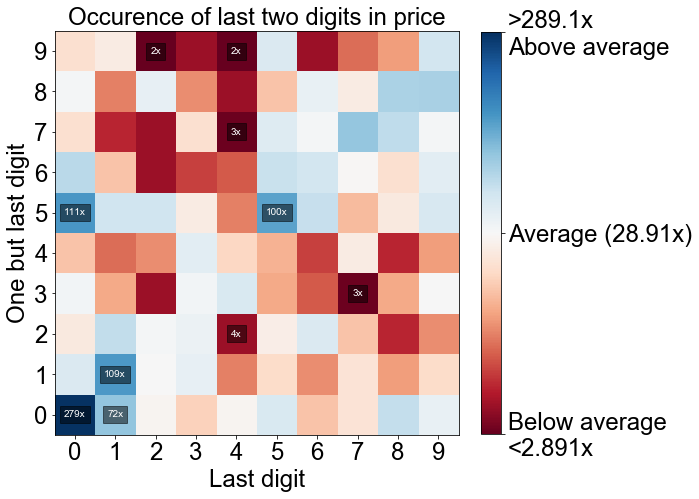

In [16]:
# plot for publication
fig,ax = plt.subplots(figsize=(8, 8))
imgplot = ax.imshow(norm_cnt,vmax=1,vmin=-1,
           cmap='RdBu',
           origin='lower')

# least and most occuring pairs
for i,d in digits.iloc[0:5,:].iterrows():
    x=d['last-0']
    y=d['last-1']
    label = '{:g}x'.format(d.occurrence)
    ax.text(x,y,label,
            color='w',
            ha='center',va='center',
            bbox={'alpha':.5,'color':'k'})
for i,d in digits.iloc[-5:,:].iterrows():
    x=d['last-0']
    y=d['last-1']
    label = '{:g}x'.format(d.occurrence)
    ax.text(x,y,label, 
            color='w',
            ha='center',va='center',
            bbox={'alpha':.5,'color':'k'})
    
# labels
ax.set_xticks(range(0,10))
ax.set_yticks(range(0,10))
ax.tick_params(labelsize=24)
ax.set_title('Occurence of last two digits in price',fontsize=24)
ax.set_xlabel('Last digit',fontsize=24,)
ax.set_ylabel('One but last digit',fontsize=24)

# colorbar
cbar = fig.colorbar(imgplot, ticks=[-1,0,+1], fraction=.045, aspect=20)
cbar.ax.set_yticklabels([
    'Below average\n<{:.3f}x'.format(cnt.ravel().sum()/1000), 
    'Average ({:.2f}x)'.format(cnt.ravel().sum()/100), 
    '>{:.1f}x\nAbove average'.format(cnt.ravel().sum()/10), 
])
cbar.ax.tick_params(labelsize=24)

# save
plt.savefig('../results/last-two-digits.png', bbox_inches='tight', transparent=True)

# Usage intensity

Distance travelled

## Odometer

180.589


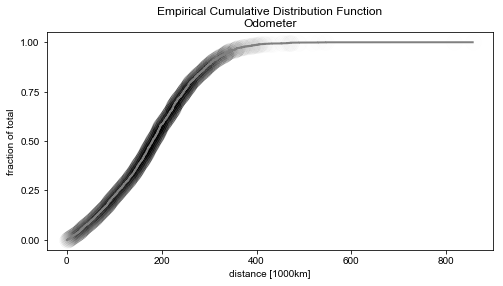

In [17]:
data = yX.odometer/1000
x,y = ecdf(data)

# plot full
plt.figure(figsize=[8,4])
plt.step(x, y, color='k', marker='o', alpha=0.0025, ms=16)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.title('Empirical Cumulative Distribution Function\nOdometer')
plt.xlabel('distance [1000km]')
plt.ylabel('fraction of total')

plt.yticks(pd.np.linspace(0,1.0,5))
# plt.xticks(pd.np.linspace(0,900,10))
# plt.grid(True)
print(pd.np.median(x))

plt.savefig('../results/odometer-ecdf.png', bbox_inches='tight', transparent=False)

## Car age

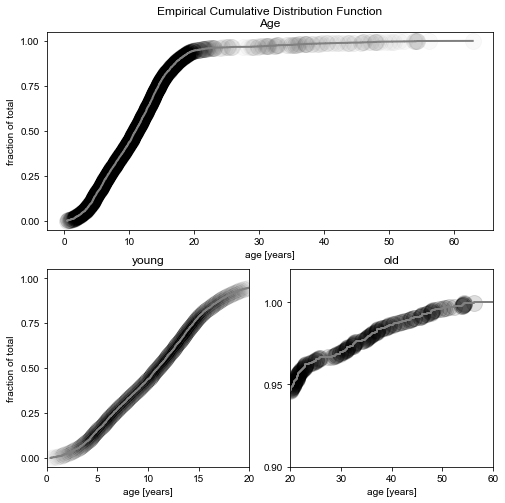

In [18]:
data = yX.age[yX.age>0]/365.25
x,y = ecdf(data)


fig,axs = plt.subplots(figsize=[8,8], ncols=2, nrows=2)
# plot full
plt.subplot(211)
plt.step(x, y, color='k', marker='o', alpha=0.025, ms=16)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.xlabel('age [years]')
plt.ylabel('fraction of total')
plt.title('Empirical Cumulative Distribution Function\nAge')
plt.yticks(pd.np.linspace(0,1.0,5))

# plot old/young
axs[1][0].step(x, y, color='k', marker='o', alpha=0.0025, ms=16)
axs[1][0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1][1].step(x, y, color='k', marker='o', alpha=0.125, ms=16)
axs[1][1].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1][0].set_yticks(pd.np.linspace(0,1.0,5))
axs[1][1].set_yticks(pd.np.linspace(0,1.0,21))
axs[1][0].set_xlim(left=0, right=20)
axs[1][1].set_xlim(left=20, right=60)
axs[1][1].set_ylim(bottom=0.9, top=1.02)
axs[1][0].set_ylabel('fraction of total')
axs[1][0].set_xlabel('age [years]')
axs[1][1].set_xlabel('age [years]')
axs[1][0].set_title('young')
axs[1][1].set_title('old')


plt.savefig('../results/age-ecdf.png', bbox_inches='tight', transparent=False)

## Usage

In [19]:
is_diesel = df.fuel == 'diesel' # for future usage
usage = df.odometer/df.age
median_usage = usage.median()

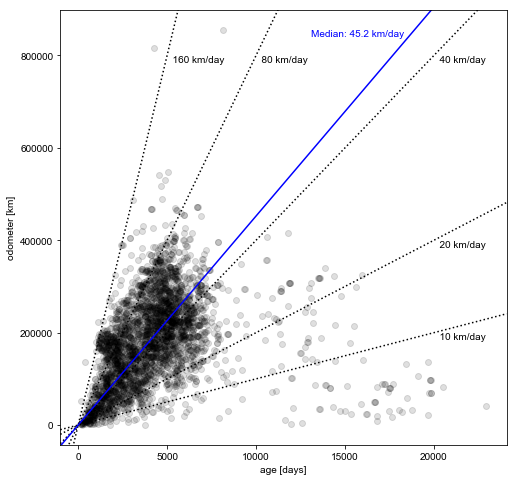

In [20]:
plt.figure(figsize=[8,8])
plt.plot(df.age,df.odometer, 'k', linestyle='None', marker='o', alpha=0.125)
plt.xlabel('age [days]')
plt.ylabel('odometer [km]')
xl = plt.xlim()
yl = plt.ylim()
for p_d in [10, 20,40,80, 160]:
    yy = [x * p_d for x in xl]
    plt.plot(xl,yy,':k')

    if p_d < 50:
        x = 20000
        y = p_d*x    
    else:
        y = 800000
        x = y/p_d
        
    plt.text(x,y,'  {} km/day'.format(p_d), va='top')

p_d = median_usage
y = [x * p_d for x in xl]
plt.plot(xl,y,'-b')
plt.text(850000/median_usage,850000,'Median: {:.1f} km/day   '.format(median_usage), ha='right', va='center_baseline', color='b')
plt.xlim(xl)
plt.ylim(yl)
# plt.xscale('log')
# plt.yscale('log')


plt.savefig('../results/usage-regression.png', bbox_inches='tight', transparent=True)

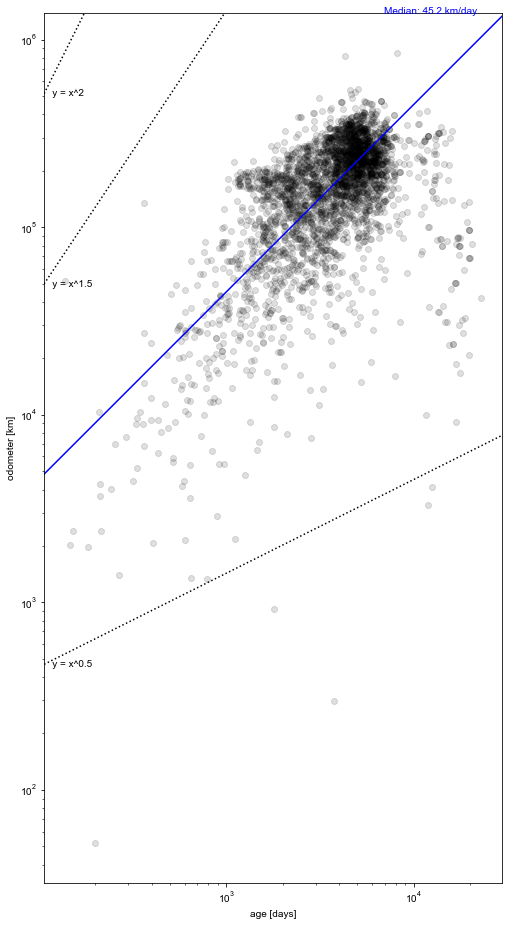

In [21]:
plt.figure(figsize=[16,16])
plt.plot(df.age,df.odometer, 'k', linestyle='None', marker='o', alpha=0.125)
plt.xlabel('age [days]')
plt.ylabel('odometer [km]')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')

xl = plt.xlim()
yl = plt.ylim()
p_d = median_usage
xx = pd.np.array(xl)
yy = xx * p_d
plt.plot(xx,yy,'-b')
plt.text(xx[1],xx[1] * p_d,'Median: {:.1f} km/day         '.format(median_usage), ha='right', va='bottom', color='b')
for angle,offset in zip([0.5, 1, 1.5, 2], [1,1,1,1]):
    if angle == 1:
        continue
    yy = xx ** angle * median_usage * offset
    plt.plot(xx,yy,':',color='k')
    plt.text(xx[0],xx[0] ** angle * median_usage * offset,'   y = x^{:g}  '.format(angle), ha='left', va='center', color='k')


plt.xlim(xl)
plt.ylim(yl)

plt.savefig('../results/usage-regression-loglog.png', bbox_inches='tight', transparent=True)

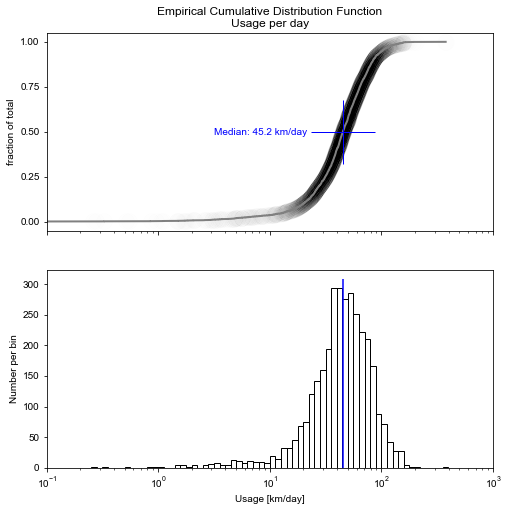

In [22]:
data = usage
x,y = ecdf(data)

# plot full
fig,axs=plt.subplots(figsize=[8,8], nrows=2, ncols=1, sharex=True)

axs[0].step(x, y, color='k', marker='o', alpha=0.005, ms=16)
axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[0].plot(median_usage, 0.5, marker='+', color='b', ms=64)
axs[0].text(median_usage,0.5,'Median: {:.1f} km/day             '.format(median_usage), ha='right', va='center_baseline', color='b')

axs[1].hist(x, bins=pd.np.logspace(-1,3,81), edgecolor='k', facecolor='None')
yl=axs[1].get_ylim()
axs[1].vlines(x=median_usage, ymin=0, ymax=yl[1], color='b')

axs[0].set_xscale('log')
axs[0].set_xlim(left=0.1, right=1000)
axs[0].set_title('Empirical Cumulative Distribution Function\nUsage per day')
axs[0].set_yticks(pd.np.linspace(0,1.0,5))
axs[1].set_xlabel('Usage [km/day]')
axs[0].set_ylabel('fraction of total')
axs[1].set_ylabel('Number per bin')

plt.savefig('../results/usage-dist.png', bbox_inches='tight', transparent=False)